In [2]:
valid_file_path = '/blob/shufxi/data/ur50split/uniref50_2023_05.shorten.valid.seqs'

seqs = []
with open(valid_file_path, 'r') as f:
    for line in f:
        seqs.append(line.strip())


In [3]:
len(seqs)

759891

In [4]:
# sort by length
seqs = sorted(seqs, key=len)

In [5]:
to_print_len = 100
for i, seq in enumerate(seqs):
    if len(seq) >= to_print_len:
        print(f'{i}: {len(seq)}')
        print(seq)
        print()
        to_print_len += 100
        if to_print_len > 1000:
            break

466: 100
IQGNITPHAIVILPKTEGMEMLVCYEDEGVYVNTYGRITKDVVLQWGEMPTSVAYIHSNQIMGWGEKAIEIRSVETGHLDGVFMHKRAQRLKFLCERNDK

1438: 200
MGTHEHALDVVVYYHHPDKAPLLRGALLPLAEACAARGTAAHVERHWLHGPHLRLRLQGPPRQVEEASESAASALRDWLREHPSHGDLTETELLERAALAGRAELVPPPYGPIEPDNTVRIQAVDRSSVRGLLGEDGAALREDLLRAGLGALRAGAGFLGEHGDGERARIRLAVTALAAHAGAHPGGLAGGHWSYVSHLE

3544: 300
FFLLLLREILDPKYGMFKEYEETRTIWFAENSFEDNDVYFLIGMILGLAIYNFTIIDIPFPLALYKKLLSEPIGLSDLKGLSPMMANSLQSLLDYEGNDMQDVFSLSFDISRDMFGEAVTIPLKPNGSNVPVTQENKQEYVNLYINYIFNESVKHQYEAFHKGFMKVCGGRVLQLFHSHELMAVVIGNENYDWHALEEAAEYKNGYKSSDQTIRWFWEVLHEMSLTDKKKFLVYLTGSYRIPIQGMKAIKIVVQPTNDDKFLPVAHTCFNLLDLPRYKTKERLRYKLMQAIQQTEGFSLV

134678: 400
MIDVPVVEAFMFSSFLNSMIAALALLGIIQATKKPNLMISTHAGMEELGVGAEFHLLVCLHNAIDVPCSINLIESCRGSGAFSLSVNTMHLIEYNERTAAQLLYRRDITHMLVGGESKQISDAFEAYRSKVAISMRHSTTISFLFNMHEDICRSADEVAASMIVLPYHMLYRDDGKMQVRNSEIRKLNQRVISHATCPVGIIIDRGLGDTSLTSAAHLSHNRNVFGLFFGGPSDREAITLGGRLSEHPDIRFTLLHFLCSRHSDGLEQSGTRVSSNSAMVQMPQQKSNPKLDSFPEIEKDQMFLNSFRRKYEKNSRVFYEERTLGTEKDLVPALQALDAECTLFIVGQGQSLA

In [13]:
import random
random.seed(0)

samples = random.sample(seqs[466:346449], 200)

In [7]:
samples[0]

'MDLTKSFFSLLALINPIGAIPFFISLTESQTDEEKRRTIKTASVSVALVIGISALLGEQIIGFFGFSVGSLQVGGGIIMIMIALNMLNAQTSRTKATPEEEDEAGVRASIAVVPLAIPLLTGPGSISTVIVYAGKTQHWYELFFLAGVGVLIALVVWVVLRAACRRADRPRDRPHRHQRRHAPDGADPCGAGRGIYRRRAENPVACSQIMTTIAIVDYGMGNLRSVAQALRAVAPDADVRISAQADEIRTADRVVLPGQGAMPDCMAAFDLSGLHDAVLEAARTKPMLGVCVGEQMLLERSTEARPGREFTRGLGLIAGDVVRFDLDGQLQPDGSRYKVPQMGWNRVHQSRAHALWAGVPDQSYFYFVHSYYARPAHPEESVGETEYGVRFTCAIARDNIFATQFHPEKSAQAGLQIYRNFVHWNP'

In [8]:
step_list = [
39645,
79290,
118935,
145365,
185010,
]

In [9]:
from sfm.data.sci_data.SFMDecTokenizer import SFMDecTokenizer
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import os
from tqdm import tqdm

/anaconda/envs/sfm2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2024-03-13 06:26:21,876] [INFO] [real_accelerator.py:133:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [10]:
tokenizer_home = '/hai1/ds_dataset/llama2/llama-2-7b'
tokenizer = SFMDecTokenizer.from_pretrained(
    tokenizer_home,
    prot_spm_path='/blob/shufxi/data/scigpt/ur50bpe/bpe',
    dna_spm_path='/blob/shufxi/data/scigpt/dnabpe/bpe',
    rna_spm_path='/blob/shufxi/data/scigpt/rnabpe/bpe',
)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'LlamaTokenizer'. 
The class this function is called from is 'SFMDecTokenizer'.


You are using the default legacy behaviour of the <class 'sfm.data.sci_data.SFMDecTokenizer.SFMDecTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


[2024-03-13 06:26:23.952][INFO]: Loading protein sentencepiece model from /blob/shufxi/data/scigpt/ur50bpe/bpe.model and /blob/shufxi/data/scigpt/ur50bpe/bpe.vocab
[2024-03-13 06:26:24.014][INFO]: Loading DNA sentencepiece model from /blob/shufxi/data/scigpt/dnabpe/bpe.model and /blob/shufxi/data/scigpt/dnabpe/bpe.vocab
[2024-03-13 06:26:24.075][INFO]: Loading RNA sentencepiece model from /blob/shufxi/data/scigpt/rnabpe/bpe.model and /blob/shufxi/data/scigpt/rnabpe/bpe.vocab
[2024-03-13 06:26:24.571][INFO]: Tokenizer has 40014 tokens


In [23]:
def load_ckpt(ckpt_home):
    ckpt_dict = {}

    layer0 = torch.load(os.path.join(ckpt_home, "layer_00-model_states.pt"), map_location=torch.device("cpu"))
    ckpt_dict['model.embed_tokens.weight'] = layer0['embed_tokens.weight']

    for l in range(0, 32):
        l_index = str(l + 1).zfill(2)
        layer = torch.load(os.path.join(ckpt_home, f"layer_{l_index}-model_states.pt"), map_location=torch.device("cpu"))
        for k in layer:
            if "dummy" in k or 'rotary_emb' in k:
                continue
            ckpt_dict[f"model.layers.{l}.{k}"] = layer[k]

    layer = torch.load(os.path.join(ckpt_home, "layer_33-model_states.pt"), map_location=torch.device("cpu"))
    ckpt_dict["model.norm.weight"] = layer["norm.weight"]

    layer = torch.load(os.path.join(ckpt_home, "layer_34-model_states.pt"), map_location=torch.device("cpu"))
    ckpt_dict["lm_head.weight"] = layer["lm_head.weight"]

    return ckpt_dict

def load_model(ckpt_dict):
    model = AutoModelForCausalLM.from_pretrained(tokenizer_home)
    model_dict = model.state_dict()
    model_dict.update(ckpt_dict)
    model.resize_token_embeddings(len(tokenizer))
    model.load_state_dict(model_dict)
    model.eval()
    model.cuda()
    return model

def score(model, seq):
    inputs = tokenizer('<protein>'+seq+'</protein>', return_tensors="pt")
    input_ids = inputs["input_ids"].cuda()
    attention_mask = inputs["attention_mask"].cuda()
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        logits = logits[0, :-1, :]
        label = input_ids[0, 1:]

        loss = torch.nn.functional.cross_entropy(logits, label)
        return loss.item()

In [24]:
scores_per_step = []

for step in step_list:
    print('scoring step', step)
    ckpt_home = f'/hai1/shufxi/scigpt/7bv3/stageB.prot/global_step{step}'
    ckpt_dict = load_ckpt(ckpt_home)
    model = load_model(ckpt_dict)
    scores = [score(model, seq) for seq in tqdm(samples)]
    scores_per_step.append(scores)
    del model

scoring step 39645


100%|██████████| 200/200 [00:31<00:00,  6.25it/s]


scoring step 79290


100%|██████████| 200/200 [00:32<00:00,  6.24it/s]


scoring step 118935


100%|██████████| 200/200 [00:32<00:00,  6.24it/s]


scoring step 145365


100%|██████████| 200/200 [00:32<00:00,  6.24it/s]


scoring step 185010


OSError: [Errno 5] Input/output error: '/hai1/shufxi/scigpt/7bv3/stageB.prot/global_step185010/layer_01-model_states.pt'

In [40]:
step = step_list[-1]
print('scoring step', step)
ckpt_home = f'/hai1/shufxi/scigpt/7bv3/stageB.prot/global_step{step}'
ckpt_dict = load_ckpt(ckpt_home)
model = load_model(ckpt_dict)
scores = [score(model, seq) for seq in tqdm(samples)]
scores_per_step.append(scores)
del model

scoring step 185010


100%|██████████| 200/200 [00:32<00:00,  6.24it/s]


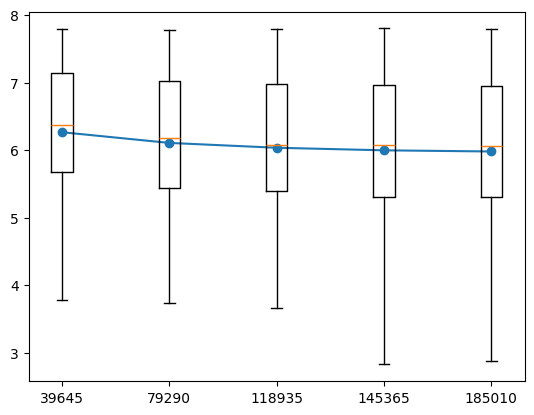

In [55]:
import matplotlib.pyplot as plt
import numpy as np

def draw(data, x_label):
    data = np.array(data)
    x = range(1, len(data) + 1)
    mean_values = np.mean(data, axis=1)
    plt.plot(x, mean_values, '-o')
    for i in range(len(data)):
        plt.boxplot(data[i, :], positions=[x[i]], widths=0.2, manage_ticks=False, showfliers=False)

    plt.xticks(x, x_label)
    plt.show()

draw(scores_per_step, step_list)


In [48]:
plt

<module 'matplotlib.pyplot' from '/anaconda/envs/sfm2/lib/python3.9/site-packages/matplotlib/pyplot.py'>

In [27]:
ckpt_home = '/blob/shufxi/scigpt/7bv3/prot/20240228025826/global_step11715'
ckpt_dict = load_ckpt(ckpt_home)
model = load_model(ckpt_dict)
scores = [score(model, seq) for seq in tqdm(samples)]
del model

100%|██████████| 200/200 [00:32<00:00,  6.25it/s]


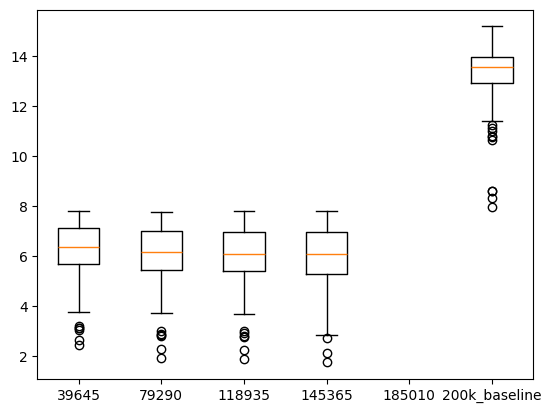

In [35]:
plt.boxplot(scores_per_step + [[]] + [scores])
plt.xticks(range(1, len(step_list) + 2), step_list + ['200k_baseline'])
plt.show()

In [36]:
! ls /blob/shufxi/scigpt/7bv3/prot/20240228025826

global_step10153  global_step4686  global_step9372  rng_state_5.pth
global_step10934  global_step5467  latest	    rng_state_6.pth
global_step11715  global_step6248  rng_state_0.pth  rng_state_7.pth
global_step1562   global_step7029  rng_state_1.pth  zero_to_fp32.py
global_step2343   global_step781   rng_state_2.pth
global_step3124   global_step7810  rng_state_3.pth
global_step3905   global_step8591  rng_state_4.pth


In [38]:
small_run_steps = [
    2343, 4686, 7029, 9372, 11715
]

scores_per_step_small = []

for step in small_run_steps:
    print('scoring step', step)
    ckpt_home = f'/blob/shufxi/scigpt/7bv3/prot/20240228025826/global_step{step}'
    ckpt_dict = load_ckpt(ckpt_home)
    model = load_model(ckpt_dict)
    scores = [score(model, seq) for seq in tqdm(samples)]
    scores_per_step_small.append(scores)
    del model


scoring step 2343


100%|██████████| 200/200 [00:32<00:00,  6.24it/s]


scoring step 4686


100%|██████████| 200/200 [00:32<00:00,  6.24it/s]


scoring step 7029


100%|██████████| 200/200 [00:32<00:00,  6.23it/s]


scoring step 9372


100%|██████████| 200/200 [00:32<00:00,  6.23it/s]


scoring step 11715


100%|██████████| 200/200 [00:32<00:00,  6.22it/s]


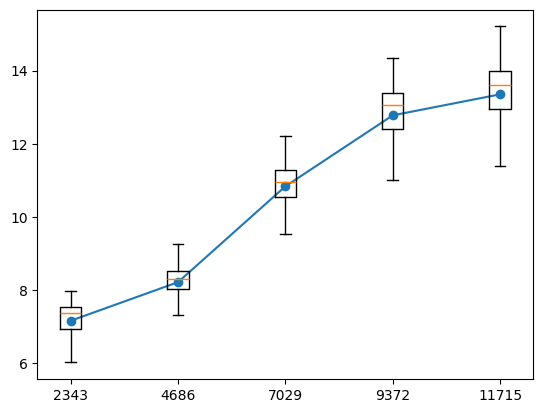

Bad pipe message: %s [b'\x152Ik\xa0\x0b\x88\x8d\x8f9\x12}M|\xf5\x06\x83\xc3 R\x96\x99\xe7\xe0\x85\xd7n\xbe\x7f7\x85\xde=\xf5\x9c\x93\x8b\xb5gAC\xbd\xceu \x98\xa0\x95\xc8[:\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b\x08\x04\x08\x05\x08\x06\x04\x01\x05\x01\x06\x01\x00+\x00\x03\x02\x03\x04\x00-\x00']
Bad pipe message: %s [b":\xda\xc2E\x16\xfe\x187\xd8\x7fF\xb13\x10\xb9\xa8\xfev\x00\x00\xa6\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0s\xc0w\x00\xc4\x00\xc3\xc0#\xc0'\x00g\x00@\xc0r\xc0v\x00\xbe\x00\xbd\xc0\n\xc0\x14\x009\x008\x00\x88\x00\x87\xc0\t\xc0\x13\x003\x00

In [56]:
draw(scores_per_step_small, small_run_steps)